In [1]:
from io import BytesIO
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import requests
from PIL import Image

In [2]:
def calc_and_plot_hog(random=False, plot=True):
    # Load the RGB cat image
    img_rgb = cv2.imread('imgs/cat.png')
    
    if random:
        # Load a random RGB image from LoremFlickr
        url = "https://loremflickr.com/256/256"
        response = requests.get(url)
        img_rgb = np.array(Image.open(BytesIO(response.content)))
    
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    
    cell_size = (8, 8)
    num_bins = 9
    
    hog = cv2.HOGDescriptor(
        _winSize=img_gray.shape,
        _blockSize=(16, 16),
        _blockStride=(8, 8),
        _cellSize=cell_size,
        _nbins=num_bins
    )
    
    hog_descriptor = hog.compute(img_gray)

    # Reshape the feature vector to [number of blocks in x and y direction, number of cells per block in x and y direction, number of bins]
    # This will be useful later when we plot the feature vector, so that the feature vector indexing matches the image indexing
    hog_descriptor_reshaped = hog_descriptor.reshape(31,
                                                     31,
                                                     2,
                                                     2,
                                                     9).transpose((1, 0, 2, 3, 4))
    
    # Create an array that will hold the average gradients for each cell
    ave_grad = np.zeros((32, 32, 9))
    
    # Create an array that will count the number of histograms per cell
    hist_counter = np.zeros((32, 32, 1))
    
    # Add up all the histograms for each cell and count the number of histograms per cell
    for i in range(2):
        for j in range(2):
            ave_grad[i:31 + i,
                     j:31 + j] += hog_descriptor_reshaped[:, :, i, j, :]
    
            hist_counter[i:31 + i,
                         j:31 + j] += 1

    # Calculate the average gradient for each cell
    ave_grad /= hist_counter
    
    # Calculate the total number of vectors we have in all the cells.
    len_vecs = ave_grad.shape[0] * ave_grad.shape[1] * ave_grad.shape[2]
    
    # Create an array that has num_bins equally spaced between 0 and 180 degress in radians.
    deg = np.linspace(0, np.pi, num_bins, endpoint=False)
    
    # Each cell will have a histogram with num_bins. For each cell, plot each bin as a vector (with its magnitude
    # equal to the height of the bin in the histogram, and its angle corresponding to the bin in the histogram).
    # To do this, create rank 1 arrays that will hold the (x,y)-coordinate of all the vectors in all the cells in the
    # image. Also, create the rank 1 arrays that will hold all the (U,V)-components of all the vectors in all the
    # cells in the image. Create the arrays that will hold all the vector positons and components.
    U = np.zeros((len_vecs))
    V = np.zeros((len_vecs))
    X = np.zeros((len_vecs))
    Y = np.zeros((len_vecs))

    # Set the counter to zero
    counter = 0
    
    # Use the cosine and sine functions to calculate the vector components (U,V) from their maginitudes. Remember the
    # cosine and sine functions take angles in radians. Calculate the vector positions and magnitudes from the
    # average gradient array
    for i in range(ave_grad.shape[0]):
        for j in range(ave_grad.shape[1]):
            for k in range(ave_grad.shape[2]):
                U[counter] = ave_grad[i, j, k] * np.cos(deg[k])
                V[counter] = ave_grad[i, j, k] * np.sin(deg[k])
    
                X[counter] = (cell_size[0] / 2) + (cell_size[0] * i)
                Y[counter] = (cell_size[1] / 2) + (cell_size[1] * j)
    
                counter = counter + 1
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
    
        ax1.set(title='Original RGB Image')
        ax1.imshow(img_rgb)
    
        # Display the image
        ax2.set(title='Grayscale Image')
        ax2.imshow(img_gray, cmap='gray')
        
        # Plot the feature vector (HOG Descriptor)
        ax3.set(title='HOG Descriptor')
        ax3.quiver(Y, X, U, V, color='white', headwidth=0, headlength=0, scale_units='inches', scale=3)
        ax3.invert_yaxis()
        ax3.set_aspect(aspect=1)
        ax3.set_facecolor('black')

    return img_gray, X, Y, U, V, ave_grad, num_bins

def plot_hog_cell(cell_num_x, cell_num_y, random=False):
    img_gray, X, Y, U, V, ave_grad, num_bins = calc_and_plot_hog(random, plot=False)
    
    x_min, x_max = cell_num_x*8,  (cell_num_x+1)*8
    y_min, y_max = cell_num_y*8,  (cell_num_y+1)*8

    img_cell = img_gray[y_min:y_max, x_min:x_max]

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(30, 5))

    # Grayscale image
    ax1.set(title='Grayscale Image')
    ax1.imshow(img_gray, cmap='gray')
    rect = patches.Rectangle((x_min, y_min), 8, 8,
                             linewidth=2, edgecolor='r', facecolor='none')
    ax1.add_patch(rect)
    ax1.axes.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)

    # Cell image
    ax2.set(title='Cell')
    ax2.imshow(img_cell, cmap='gray')
    ax2.xaxis.set_ticks_position('none')
    ax2.axes.xaxis.set_visible(False)
    ax2.axes.yaxis.set_visible(False)

    # Image gradients of the cell
    ax3.set(title='Gradients (Cell)')
    ax3.imshow(img_cell, cmap='gray')
    dY, dX = np.gradient(img_cell)
    ax3.quiver(dX, -dY, color='red')
    ax3.axes.xaxis.set_visible(False)
    ax3.axes.yaxis.set_visible(False)

    # Hog image of the cell
    ax4.set(title='HOG Image (Cell)')
    ax4.quiver(Y, X, U, V, color='white', headwidth=0, headlength=0,
               scale_units='inches', width=0.01, scale=0.3)
    ax4.set_xlim(x_min, x_max)
    ax4.set_ylim(y_min, y_max)
    ax4.invert_yaxis()
    ax4.set_aspect(aspect=1)
    ax4.set_facecolor('black')
    ax4.axes.xaxis.set_visible(False)
    ax4.axes.yaxis.set_visible(False)

    # Histogram of the gradients
    ax5.set(title='Histogram of Gradients (Cell)')
    angle_axis = np.linspace(0, 180, num_bins, endpoint=False)
    angle_axis += ((angle_axis[1] - angle_axis[0]) / 2)
    ax5.grid()
    ax5.set_xlim(0, 180)
    ax5.set_xticks(angle_axis)
    ax5.set_xlabel('Angle')
    ax5.bar(angle_axis, ave_grad[cell_num_y, cell_num_x, :], 180 //
            num_bins, align='center', alpha=0.5, linewidth=1.2, edgecolor='k')

## Visualizing the HOG Descriptor

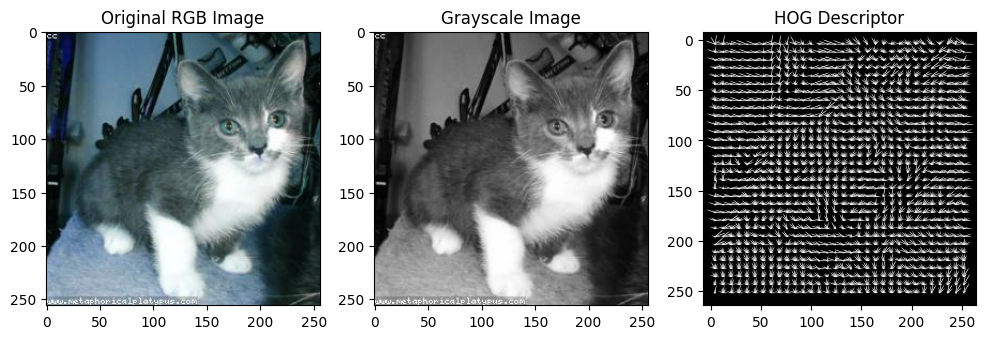

In [3]:
#plot_hog();
calc_and_plot_hog();

## A Closer Look

### Horziontal Edge

We selected a cell in the image that encloses a horizontal edge. Edges are areas in an image where pixel density changes abruptly. When we examine the gradients, we see a high rate of vertical changes. For this reason, as we can see in the histogram, the 90 degree bin will be quite dominant compared to the other bins.

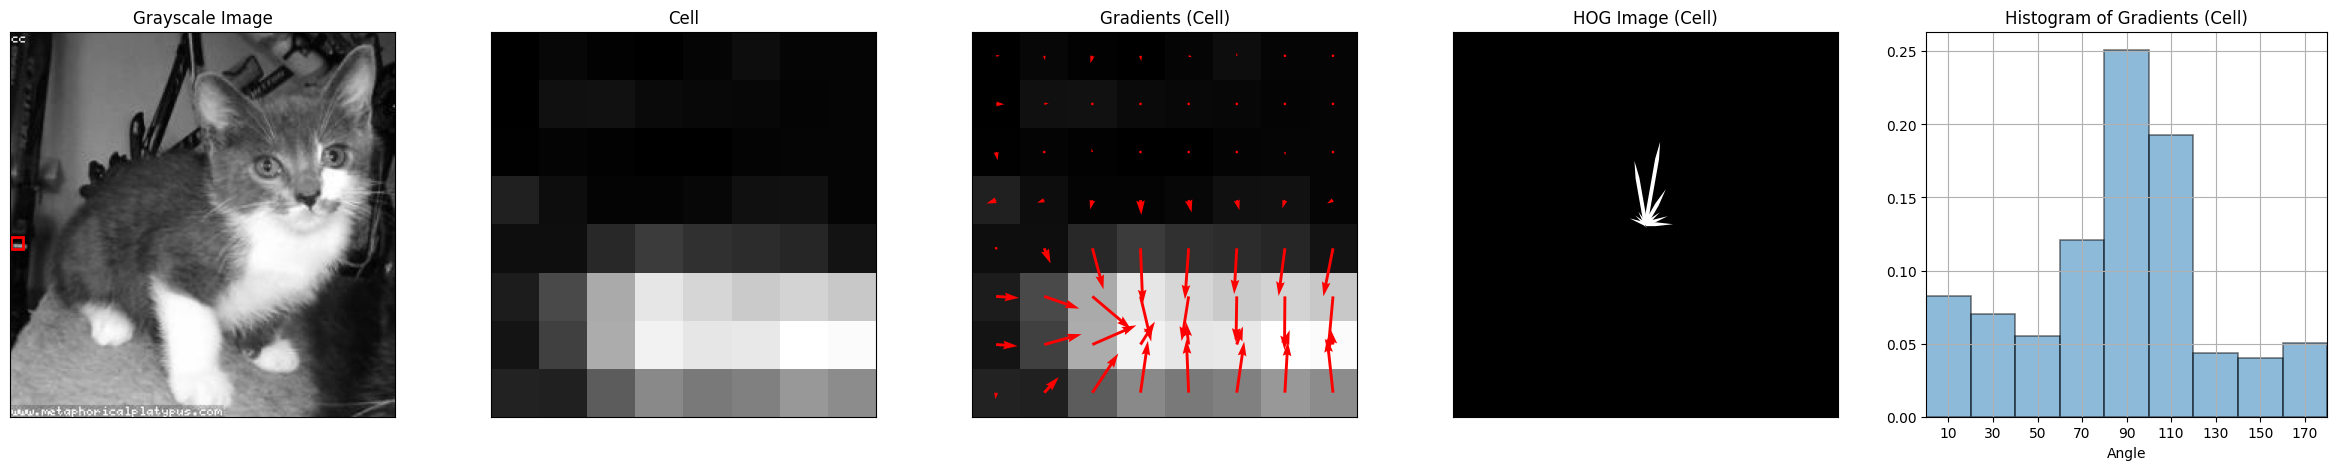

In [6]:
plot_hog_cell(0, 17)

### Vertical Edge

When examining a cell with a vertical edge, we observe significant horizontal changes in pixel gradients, leading to dominance in the 0–30 degree and 160–180 degree bins in the histogram, particularly over the 90-degree bin. This occurs because the HOG algorithm employs unsigned gradients, treating 0 and 180-degree gradients as equivalent, resulting in both the 0–10 degree and 170–180 degree bins being prominent.

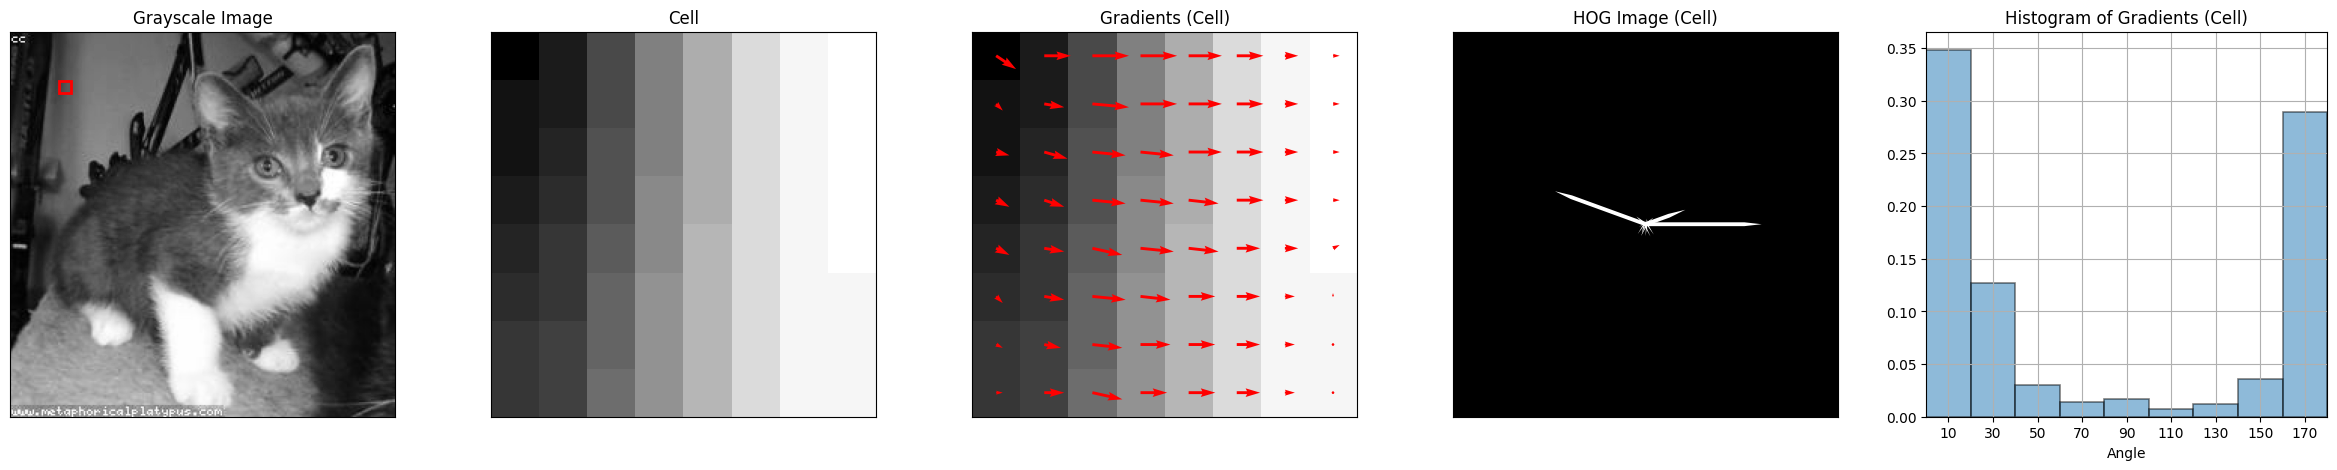

In [7]:
plot_hog_cell(4, 4)

### Circular

If we select a cell that encloses a black circle, we can examine a high rate of gradient changes in both the vertical and horizontal direction. For this reason, all bins are equally dominant.

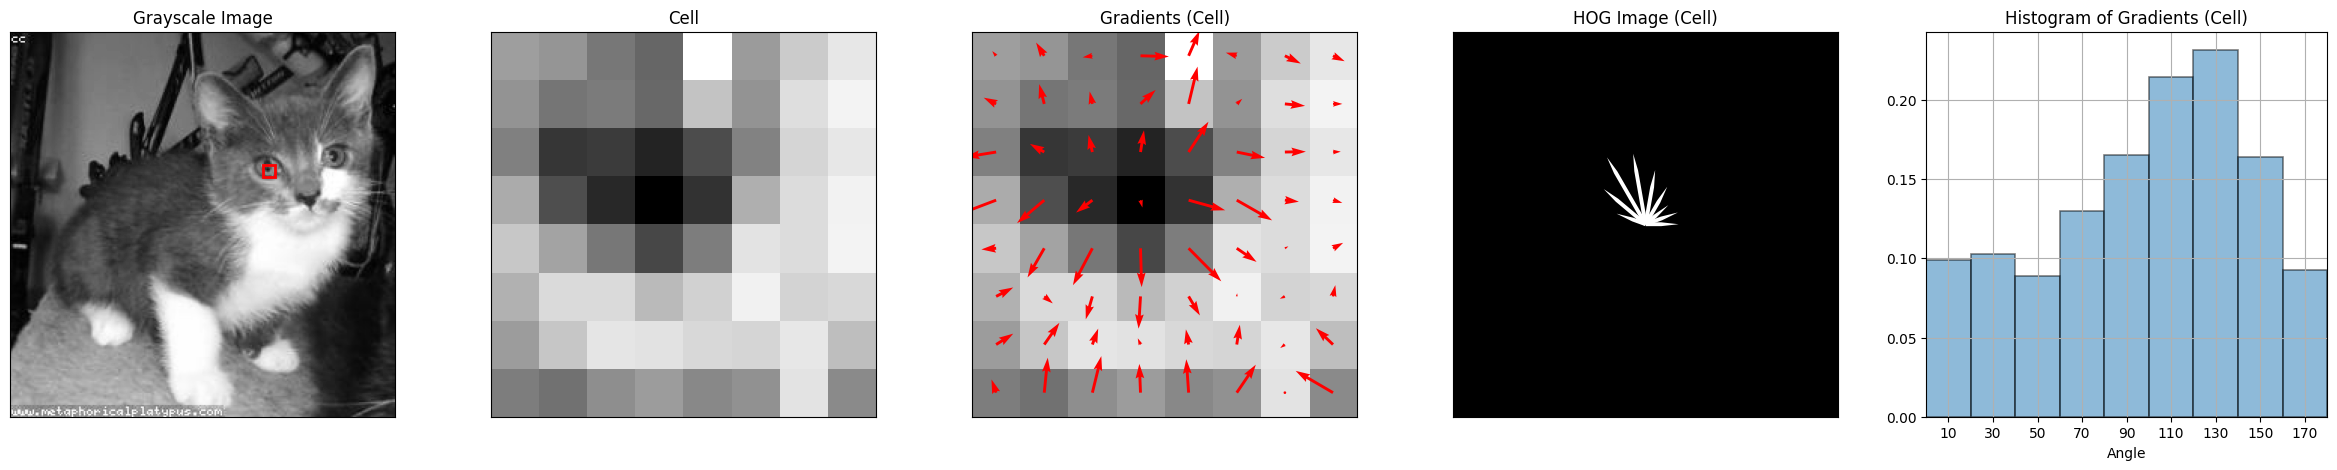

In [9]:
plot_hog_cell(21, 11)

## More Random Examples

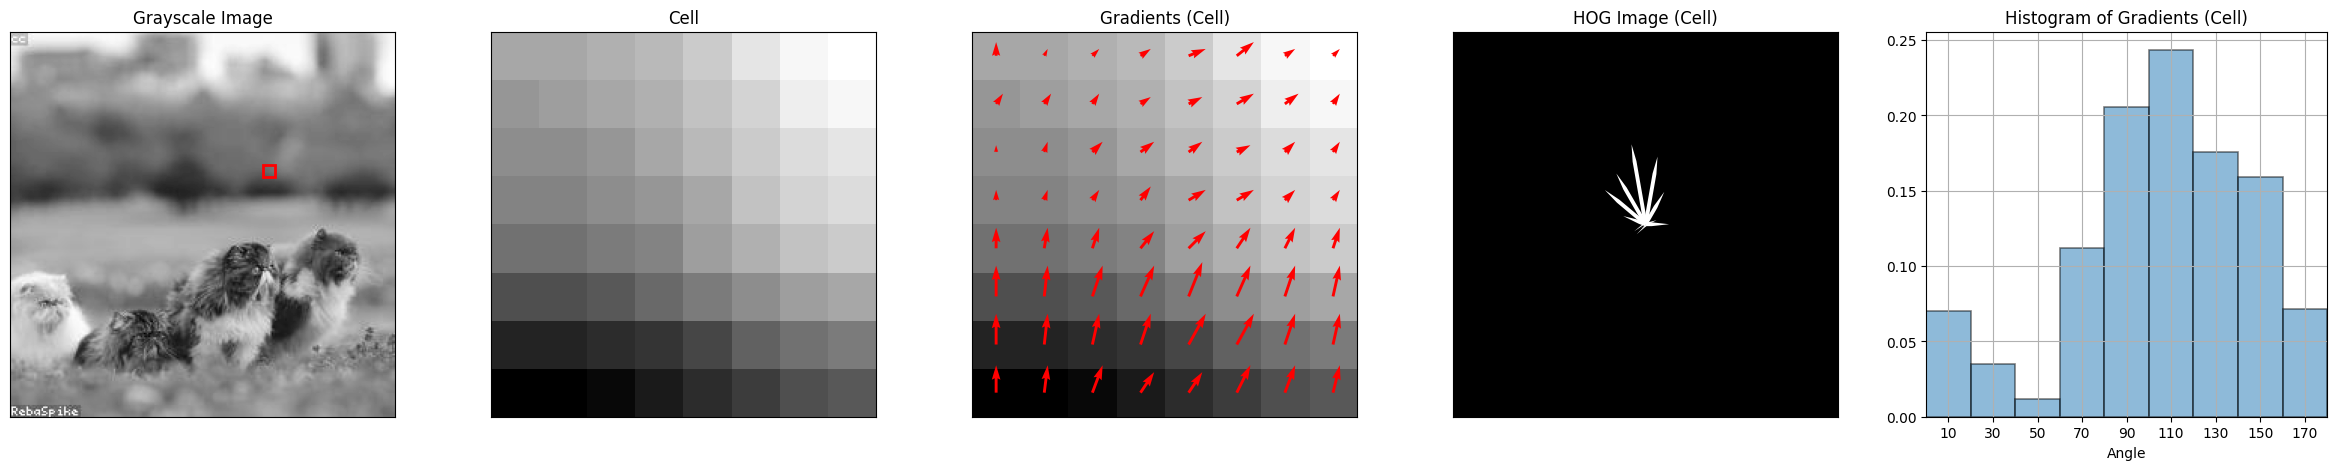

In [18]:
plot_hog_cell(21, 11, random=True)

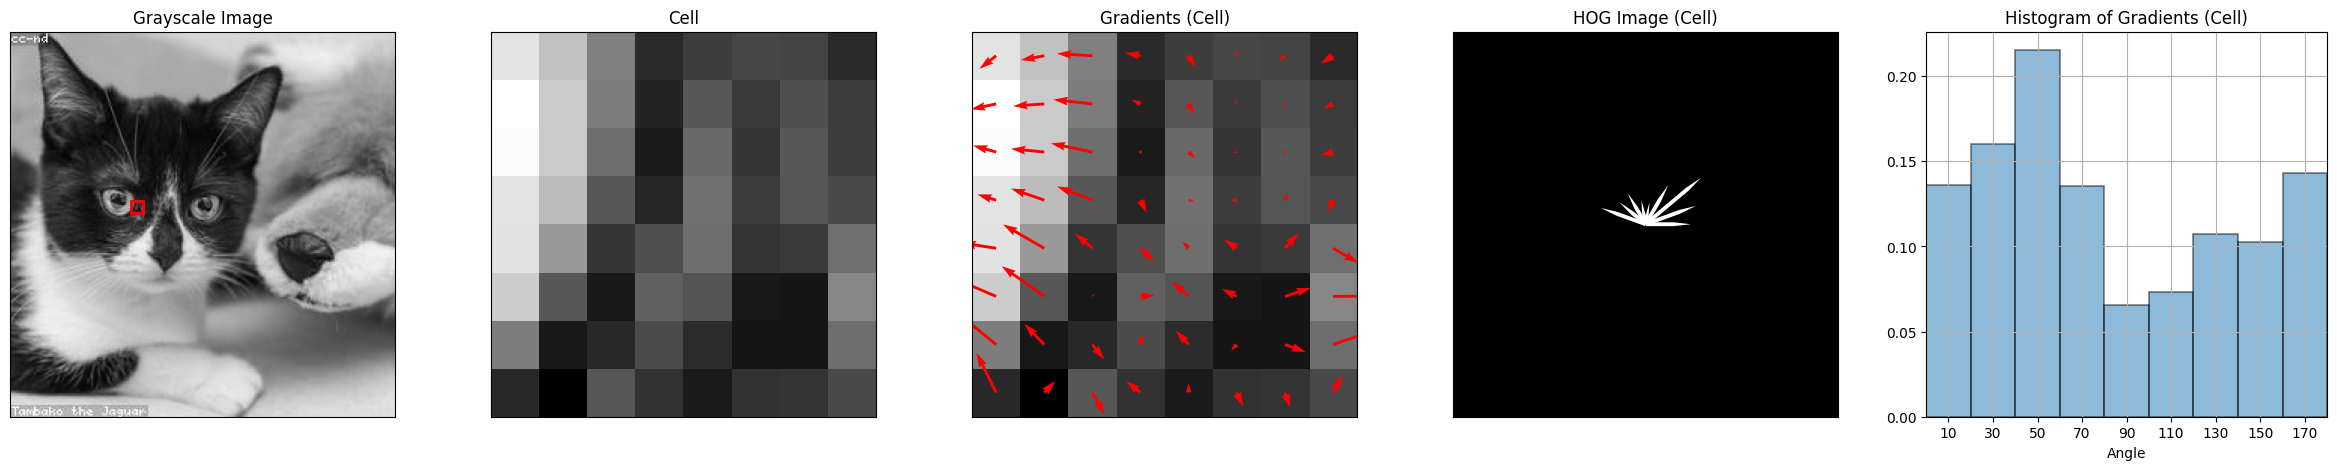

In [17]:
plot_hog_cell(10, 14, random=True)

In [ ]:
plot_hog_cell(4, 16, random=True)